<a href="https://colab.research.google.com/github/CNsquared/breast-cancer-team-1/blob/main/project-4/notebooks/personal/ari/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# ! mv /content/breast-cancer-team-1/project-4/data/raw/TCGA.BRCA.expression.txt /content/TCGA.BRCA.expression.txt
# ! mv /content/breast-cancer-team-1/project-4/data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv /content/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv
# ! mv /content/breast-cancer-team-1/project-4/data/raw/dndscv.csv /content/dndscv.csv
%cd /content
!rm -rf breast-cancer-team-1

/content


In [ ]:
#!git clone -b Arivoli-A-pr4-argparser --single-branch https://github.com/CNsquared/breast-cancer-team-1.git
!git clone -b dropout https://github.com/CNsquared/breast-cancer-team-1.git

Cloning into 'breast-cancer-team-1'...
remote: Enumerating objects: 1803, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 1803 (delta 42), reused 43 (delta 26), pack-reused 1729 (from 1)
Receiving objects: 100% (1803/1803), 332.13 MiB | 24.99 MiB/s, done.
Resolving deltas: 100% (1089/1089), done.
Updating files: 100% (172/172), done.


In [ ]:
%cd breast-cancer-team-1/project-4/
%ls

/content/breast-cancer-team-1/project-4
data/                main.py     OG_main.py        README.md  scripts/   src/
main_no_sampling.py  notebooks/  project4_env.yml  results/   setup.sh*


In [ ]:
! wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_23/GRCh37_mapping/gencode.v23lift37.pc_transcripts.fa.gz
! gunzip gencode.v23lift37.pc_transcripts.fa.gz
! mv gencode.v23lift37.pc_transcripts.fa data/raw/gencode.v23lift37.pc_transcripts.fa
! rm -rf gencode.v23lift37.pc_transcripts.fa.gz

link_exp = 'https://www.dropbox.com/scl/fo/7d37xqur5vlb8jni61b0t/AIULq2j8qwiKujKLUdwZ1fA/Team_1_BRCA?rlkey=pfw7xmb7slnz7d398gzfzpju7&subfolder_nav_tracking=1&st=ao5mzt3l&dl=1'

! wget -O myfolder.zip $link_exp
! unzip myfolder.zip
! mv TCGA.BRCA.expression.txt data/raw/TCGA.BRCA.expression.txt
! rm -rf myfolder.zip

link_cox = 'https://drive.google.com/uc?id=1gdDy5GgMYg3Ir_iV-OEjFMzYy2usd9OJ'
! gdown $link_cox
! mv brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv data/raw

link_dndscv = 'https://drive.google.com/uc?id=1a_Zd6pZrCpGowaM9bYDmtPy6uSvPx8ik'
! gdown $link_dndscv
! mv dndscv.csv data/raw/dndscv.csv


--2025-05-30 20:20:08--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_23/GRCh37_mapping/gencode.v23lift37.pc_transcripts.fa.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29289278 (28M) [application/x-gzip]
Saving to: ‘gencode.v23lift37.pc_transcripts.fa.gz’

gencode.v23lift37.p 100%[===================>]  27.93M  18.3MB/s    in 1.5s    

2025-05-30 20:20:10 (18.3 MB/s) - ‘gencode.v23lift37.pc_transcripts.fa.gz’ saved [29289278/29289278]

--2025-05-30 20:20:12--  https://www.dropbox.com/scl/fo/7d37xqur5vlb8jni61b0t/AIULq2j8qwiKujKLUdwZ1fA/Team_1_BRCA?rlkey=pfw7xmb7slnz7d398gzfzpju7
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucebdba

In [ ]:
! mv /content/TCGA.BRCA.expression.txt /content/breast-cancer-team-1/project-4/data/raw/TCGA.BRCA.expression.txt
! mv /content/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv /content/breast-cancer-team-1/project-4/data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv
! mv /content/dndscv.csv /content/breast-cancer-team-1/project-4/data/raw/dndscv.csv

In [ ]:
from src.utils.preprocess import MutPreprocessor
from src.utils.preprocess import GeneExpPreprocessor
from src.models.autoencoder_runner import GeneExpressionRunner
from src.models.autoencoder import GeneExpressionAutoencoder
from src.utils.data_loader import load_expression_matrix
from src.utils.sampling import SamplingRunner
import numpy as np
import pandas as pd
import torch
import os

import datetime

geneExpParams = {
    'top_N': 250,
    'subset_method': 'dndscv'    # method to subset genes {dndscv, variance}
}

autoEncoderParams = {
    'latent_dim': 5,            # Number of latent features
    'hidden_dims': [128,64],    # Hidden layers
    'lr': 5e-4,                 # Learning rate
    'dropout_rate': 0.2,        # dropout rate for the autoencoder
    'weight_decay': 1e-5        # Weight decay for the optimizer (L2 regularization)
}

trainingParams = {
    'patience': 10,            # Number of epochs where model training saturated
    'max_epochs': 200,         # Maximum epochs
    'delta': 1e-4,            # Minimum change in validation loss to consider improvement
}


In [ ]:
# get expression data
all_exp = GeneExpPreprocessor(**geneExpParams, filter_subtypes=False, save=True).get_df()
basal_samples = GeneExpPreprocessor(**geneExpParams).get_df().index
basal_exp = all_exp.loc[basal_samples]
print(f"Expression data shape (train data): {all_exp.shape}")

# create runner for autoencoder
runner = GeneExpressionRunner(all_exp, **autoEncoderParams)

# run cross validation
cv_losses = runner.cross_validate()
print(f'cv_losses: {cv_losses}')

# train on all samples and get model, scaler
model, scaler, weights_all = runner.train_all_and_encode(**trainingParams, return_model=True)

# use model and scaler to encode subtypes
print("Running subtype-specific latent_space extraction...")
subtypes= ['BRCA_LumA', 'BRCA_Her2', 'BRCA_LumB', 'BRCA_Normal', 'BRCA_Basal']
for subtype in subtypes:
    subtype_samples = GeneExpPreprocessor(**geneExpParams, subtypes=[subtype]).get_df().index
    subtype_exp = all_exp.loc[subtype_samples]
    print(f"{subtype} Expression data shape: {subtype_exp.shape}")
    latent = runner.trained_model_encode(model, subtype_exp, scaler)

    # train on all samples and get latent space
    df_latent = pd.DataFrame(latent, index=subtype_exp.index, columns=[f"latent_{i}" for i in range(latent.shape[1])])
    df_latent.to_csv(f"results/tables/latent_space_{autoEncoderParams['latent_dim']}dim_{subtype}.csv")
    print("Done extracting latent space for subtype:", subtype)

# write out latent space, weights, cv losses, and pretrained model
print("Saving results...")

os.makedirs("results/models", exist_ok=True)
timestamp = datetime.datetime.now().strftime("%d_%H-%M")
str_AE_params = "_".join([
    f"{v:.0e}" if isinstance(v, float) else str(v)
    for v in autoEncoderParams.values()
])
torch.save(model.state_dict(), f"results/models/no_sampling_autoencoder_{timestamp}_model_{str_AE_params}.pth")  # save model state

weights_all = pd.DataFrame(weights_all, index=all_exp.columns)
weights_all.to_csv(f"results/tables/no_sampling_gene_to_latent_weights.csv")

cv_losses_df = pd.DataFrame(cv_losses, index=[f"fold_{i+1}" for i in range(len(cv_losses))])
cv_losses_df.to_csv(f"results/tables/no_sampling_cv_losses.csv", index=False, header=False)
print("Job completed successfully!")

Loaded matrix with 1132 samples x 20531 genes
Parsing gencode fasta file: data/raw/gencode.v23lift37.pc_transcripts.fa
Finding longest CDS length for each gene
Normalizing expression data to log1p(TPM)
Filtering out lowly expressed genes with mean expression of 1
Filtering out lowest 50.0% of genes
Subsetting to top 250 genes using method: dndscv
Loaded matrix with 1132 samples x 20531 genes
Parsing gencode fasta file: data/raw/gencode.v23lift37.pc_transcripts.fa
Finding longest CDS length for each gene
Normalizing expression data to log1p(TPM)
Subset data to patients with subtype: ['BRCA_Basal']
Subset data to 171 patients with subtype: ['BRCA_Basal']
Filtering out lowly expressed genes with mean expression of 1
Filtering out lowest 50.0% of genes
Subsetting to top 250 genes using method: dndscv
Expression data shape (train data): (1132, 250)
Using device: cpu
Performing cross-validation using training data
Fold 1/5 - Val Loss: 0.5342
Fold 2/5 - Val Loss: 0.5214
Fold 3/5 - Val Loss: 0

In [ ]:
GeneExpPreprocessor(top_N=5946, subtypes=['BRCA_Her2']).get_df()

Loaded matrix with 1132 samples x 20531 genes
Parsing gencode fasta file: data/raw/gencode.v23lift37.pc_transcripts.fa
Finding longest CDS length for each gene
Normalizing expression data to log1p(TPM)
Subset data to patients with subtype: ['BRCA_Her2']
Subset data to 78 patients with subtype: ['BRCA_Her2']
Filtering out lowly expressed genes with mean expression of 1
Filtering out lowest 50.0% of genes
Subsetting to top 5946 genes using method: dndscv


,,TP53,DEFB1,RPL35,MT2A,HIST1H2BK,WBSCR27,SCGB2A1,S100A10,GJA5,FAM131B,...,PKIA,GNG4,ENHO,RPL38,GNG7,POLR2K,PCP4L1,GNG12,MT1M,MT1F
patient_id,sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,3.087320,0.879955,7.140194,6.719702,6.345916,3.424978,4.257425,6.929093,2.504530,1.816993,...,2.623402,6.012020,1.868448,7.252945,3.218207,5.389389,2.414929,5.437060,1.002206,3.699475
TCGA-A2-A04W,TCGA-A2-A04W-01A-31R-A115-07,4.113434,3.418086,7.324118,7.366335,5.302349,1.696421,5.935223,7.601829,2.922777,3.413590,...,3.940117,2.953066,0.751672,7.418982,3.628028,5.315709,3.624702,6.497142,1.178913,4.183153
TCGA-A2-A04X,TCGA-A2-A04X-01A-21R-A034-07,4.222575,0.974871,7.111970,6.936183,5.730792,1.795134,4.956335,6.686445,2.667899,0.299174,...,1.634424,1.978481,1.678976,7.087063,3.746145,5.623837,0.360768,6.222275,1.154402,3.256069
TCGA-A2-A0CX,TCGA-A2-A0CX-01A-21R-A00Z-07,4.437976,0.101690,6.810588,6.633477,6.045369,0.470287,2.497768,6.211853,3.698240,1.319478,...,5.063304,1.143564,2.430012,7.831028,2.504625,5.826319,2.383933,6.593668,1.330513,3.505020
TCGA-A2-A0D1,TCGA-A2-A0D1-01A-11R-A034-07,3.231259,6.244164,7.815985,6.603108,5.213607,1.660107,1.141676,7.405946,2.008723,0.703361,...,1.069471,2.093064,3.853223,7.674036,4.069814,6.291372,0.604628,4.836658,0.978746,4.459391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-GM-A2DH,TCGA-GM-A2DH-01A-11R-A180-07,3.722889,1.495811,6.683992,6.891218,5.440202,2.171397,0.604129,5.737262,2.220165,1.812450,...,3.043172,4.809322,4.329073,7.089385,2.623674,6.117150,2.805714,4.920942,1.741531,4.195970
TCGA-LL-A5YO,TCGA-LL-A5YO-01A-21R-A28M-07,4.551045,1.534128,7.536990,6.471992,5.972721,0.605017,2.791071,6.659902,2.141093,0.816110,...,2.708267,2.609889,2.532816,7.378198,4.404625,5.974955,1.342604,5.663427,2.206387,3.194095
TCGA-OL-A5RZ,TCGA-OL-A5RZ-01A-11R-A28M-07,4.091703,0.718902,7.759104,7.121714,5.473264,2.767581,0.080682,4.744245,1.568074,0.414717,...,0.766575,4.506261,2.344549,8.419010,3.324023,6.352372,0.300637,3.686295,1.366780,4.300409


# Survival

In [ ]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.3 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1.0.4:
      Successfully uninstalled osqp-1.0.4


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import set_config
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [ ]:
link = 'https://drive.google.com/uc?export=download&id=1gdDy5GgMYg3Ir_iV-OEjFMzYy2usd9OJ'

In [ ]:
data = pd.read_csv(link, sep='\t')
for col in data.columns:
  print(col)
  print('No of unique entries :', len(data[col].unique()))
  print('Unique Entries : ',data[col].unique())

Study ID
No of unique entries : 1
Unique Entries :  ['brca_tcga_pan_can_atlas_2018']
Patient ID
No of unique entries : 1084
Unique Entries :  ['TCGA-3C-AAAU' 'TCGA-3C-AALI' 'TCGA-3C-AALJ' ... 'TCGA-XX-A89A'
 'TCGA-Z7-A8R5' 'TCGA-Z7-A8R6']
Sample ID
No of unique entries : 1084
Unique Entries :  ['TCGA-3C-AAAU-01' 'TCGA-3C-AALI-01' 'TCGA-3C-AALJ-01' ...
 'TCGA-XX-A89A-01' 'TCGA-Z7-A8R5-01' 'TCGA-Z7-A8R6-01']
Diagnosis Age
No of unique entries : 65
Unique Entries :  [55 50 62 52 42 70 59 56 54 61 39 77 67 40 45 66 36 48 47 34 53 60 37 85
 73 71 41 46 76 64 63 58 79 80 82 51 74 49 44 90 35 57 78 72 65 84 68 69
 75 81 89 43 83 87 88 29 32 31 38 27 26 30 86 28 33]
Neoplasm Disease Stage American Joint Committee on Cancer Code
No of unique entries : 13
Unique Entries :  ['STAGE X' 'STAGE IIB' 'STAGE IA' 'STAGE IIIA' 'STAGE IIA' 'STAGE I'
 'STAGE IIIC' 'STAGE IV' 'STAGE IB' 'STAGE IIIB' 'STAGE III' 'STAGE II'
 nan]
American Joint Committee on Cancer Publication Version Type
No of unique entrie

In [ ]:
unique_1_cols = data.columns[data.nunique() == 1].tolist()
print(unique_1_cols)

['Study ID', 'Cancer Type', 'TCGA PanCanAtlas Cancer Type Acronym', 'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value', 'Informed consent verified', 'Number of Samples Per Patient', 'Sample Type', 'Somatic Status', 'Tumor Disease Anatomic Site']


In [ ]:
less_info = ['Study ID','American Joint Committee on Cancer Publication Version Type','Cancer Type','TCGA PanCanAtlas Cancer Type Acronym','Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value','Neoplasm Histologic Grade','Number of Samples Per Patient','Sample Type','Somatic Status','Tissue Source Site','Tissue Source Site Code','Tumor Disease Anatomic Site','Patient Weight','Informed consent verified']
data.drop(less_info, axis=1, inplace=True)

In [ ]:
data.head()

,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type Detailed,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,Disease Free (Months),...,Radiation Therapy,Ragnum Hypoxia Score,Sex,Subtype,Tumor Break Load,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,TMB (nonsynonymous),Tumor Type,Winter Hypoxia Score
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55,STAGE X,19.0,-21.0,Breast Invasive Lobular Carcinoma,4047.0,-20211.0,59.440444,...,No,0.0,Female,BRCA_LumA,205.0,No,Yes,0.800000,Infiltrating Lobular Carcinoma,-28.0
1,TCGA-3C-AALI,TCGA-3C-AALI-01,50,STAGE IIB,22.0,5.0,Breast Invasive Ductal Carcinoma,4005.0,-18538.0,131.669790,...,Yes,18.0,Female,BRCA_Her2,190.0,No,Yes,15.266667,Infiltrating Ductal Carcinoma,20.0
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62,STAGE IIB,13.0,-5.0,Breast Invasive Ductal Carcinoma,1474.0,-22848.0,48.459743,...,No,12.0,Female,BRCA_LumB,365.0,No,Yes,0.933333,Infiltrating Ductal Carcinoma,-10.0
3,TCGA-3C-AALK,TCGA-3C-AALK-01,52,STAGE IA,4.0,-27.0,Breast Invasive Ductal Carcinoma,1448.0,-19074.0,NaN,...,No,2.0,Female,BRCA_LumA,25.0,No,Yes,1.500000,Infiltrating Ductal Carcinoma,4.0
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50,STAGE IIIA,7.0,-27.0,Breast Invasive Lobular Carcinoma,348.0,-18371.0,11.440971,...,No,-4.0,Female,BRCA_LumA,36.0,Yes,No,0.700000,Infiltrating Lobular Carcinoma,-20.0


In [ ]:
modify =['Disease Free Status','Cancer Type Detailed','Disease-specific Survival status','Ethnicity Category','In PanCan Pathway Analysis','Overall Survival Status','Progression Free Status','Primary Lymph Node Presentation Assessment','Prior Diagnosis','Race Category','Radiation Therapy','Subtype','Tissue Prospective Collection Indicator','Tissue Retrospective Collection Indicator','Tumor Type']

In [ ]:
data[modify].head()

,Disease Free Status,Cancer Type Detailed,Disease-specific Survival status,Ethnicity Category,In PanCan Pathway Analysis,Overall Survival Status,Progression Free Status,Primary Lymph Node Presentation Assessment,Prior Diagnosis,Race Category,Radiation Therapy,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tumor Type
0,1:Recurred/Progressed,Breast Invasive Lobular Carcinoma,0:ALIVE OR DEAD TUMOR FREE,Not Hispanic Or Latino,Yes,0:LIVING,1:PROGRESSION,Yes,No,White,No,BRCA_LumA,No,Yes,Infiltrating Lobular Carcinoma
1,0:DiseaseFree,Breast Invasive Ductal Carcinoma,0:ALIVE OR DEAD TUMOR FREE,Not Hispanic Or Latino,Yes,0:LIVING,0:CENSORED,Yes,No,Black or African American,Yes,BRCA_Her2,No,Yes,Infiltrating Ductal Carcinoma
2,0:DiseaseFree,Breast Invasive Ductal Carcinoma,0:ALIVE OR DEAD TUMOR FREE,Not Hispanic Or Latino,Yes,0:LIVING,0:CENSORED,Yes,No,Black or African American,No,BRCA_LumB,No,Yes,Infiltrating Ductal Carcinoma
3,NaN,Breast Invasive Ductal Carcinoma,0:ALIVE OR DEAD TUMOR FREE,Not Hispanic Or Latino,Yes,0:LIVING,0:CENSORED,Yes,No,Black or African American,No,BRCA_LumA,No,Yes,Infiltrating Ductal Carcinoma
4,0:DiseaseFree,Breast Invasive Lobular Carcinoma,0:ALIVE OR DEAD TUMOR FREE,Not Hispanic Or Latino,Yes,0:LIVING,0:CENSORED,Yes,No,White,No,BRCA_LumA,Yes,No,Infiltrating Lobular Carcinoma


In [ ]:
data.drop(columns=modify)

,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,Aneuploidy Score,Buffa Hypoxia Score,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,Disease Free (Months),Months of disease-specific survival,...,American Joint Committee on Cancer Metastasis Stage Code,Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Tumor Stage Code,Person Neoplasm Cancer Status,Progress Free Survival (Months),Ragnum Hypoxia Score,Sex,Tumor Break Load,TMB (nonsynonymous),Winter Hypoxia Score
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55,STAGE X,19.0,-21.0,4047.0,-20211.0,59.440444,133.050597,...,MX,NX,TX,With Tumor,59.440444,0.0,Female,205.0,0.800000,-28.0
1,TCGA-3C-AALI,TCGA-3C-AALI-01,50,STAGE IIB,22.0,5.0,4005.0,-18538.0,131.669790,131.669790,...,M0,N1A,T2,Tumor Free,131.669790,18.0,Female,190.0,15.266667,20.0
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62,STAGE IIB,13.0,-5.0,1474.0,-22848.0,48.459743,48.459743,...,M0,N1A,T2,Tumor Free,48.459743,12.0,Female,365.0,0.933333,-10.0
3,TCGA-3C-AALK,TCGA-3C-AALK-01,52,STAGE IA,4.0,-27.0,1448.0,-19074.0,NaN,47.604958,...,M0,N0 (I+),T1C,Tumor Free,47.604958,2.0,Female,25.0,1.500000,4.0
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50,STAGE IIIA,7.0,-27.0,348.0,-18371.0,11.440971,11.440971,...,M0,N2A,T2,Tumor Free,11.440971,-4.0,Female,36.0,0.700000,-20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,TCGA-WT-AB44,TCGA-WT-AB44-01,77,STAGE IA,18.0,-21.0,883.0,NaN,29.029819,29.029819,...,MX,N0 (I-),T1C,Tumor Free,29.029819,-12.0,Female,12.0,1.033333,-8.0
1080,TCGA-XX-A899,TCGA-XX-A899-01,46,STAGE IIIA,4.0,-37.0,467.0,-17022.0,15.353256,15.353256,...,MX,N2A,T1C,Tumor Free,15.353256,-8.0,Female,59.0,2.466667,-38.0
1081,TCGA-XX-A89A,TCGA-XX-A89A-01,68,STAGE IIB,32.0,-31.0,488.0,-25000.0,16.043660,16.043660,...,MX,N0,T3,Tumor Free,16.043660,-10.0,Female,51.0,5.033333,-28.0
1082,TCGA-Z7-A8R5,TCGA-Z7-A8R5-01,61,STAGE IIIA,21.0,-13.0,3287.0,-22280.0,NaN,108.064569,...,MX,N1A,T3,Tumor Free,5.950620,-16.0,Female,7.0,0.766667,-12.0


In [ ]:
category_cols = data.columns[data.nunique()<=10].tolist()
for col in category_cols:
  data[col] = data[col].astype('category')

In [ ]:
data.columns

Index(['Patient ID', 'Sample ID', 'Diagnosis Age',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'Aneuploidy Score', 'Buffa Hypoxia Score', 'Cancer Type Detailed',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date', 'Disease Free (Months)',
       'Disease Free Status', 'Months of disease-specific survival',
       'Disease-specific Survival status', 'Ethnicity Category',
       'Form completion date', 'Fraction Genome Altered',
       'Genetic Ancestry Label',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',
       'In PanCan Pathway Analysis', 'Informed consent verified',
       'MSI MANTIS Score', 'MSIsensor Score', 'Mutat

In [ ]:
endpoint = ['Disease Free Status','Disease Free (Months)','Disease-specific Survival status','Overall Survival Status','Overall Survival (Months)','Progression Free Status','Progress Free Survival (Months)']

In [ ]:
data_endpoint = data[endpoint]
data_endpoint.head()

,Disease Free Status,Disease Free (Months),Disease-specific Survival status,Overall Survival Status,Overall Survival (Months),Progression Free Status,Progress Free Survival (Months)
0,1.0,59.440444,0.0,0.0,133.050597,1.0,59.440444
1,0.0,131.669790,0.0,0.0,131.669790,0.0,131.669790
2,0.0,48.459743,0.0,0.0,48.459743,0.0,48.459743
3,NaN,NaN,0.0,0.0,47.604958,0.0,47.604958
4,0.0,11.440971,0.0,0.0,11.440971,0.0,11.440971


<ipython-input-45-4b2b5cef72b3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data_endpoint, x='Disease Free (Months)', y='Disease Free Status', inner='box', palette='Dark2')


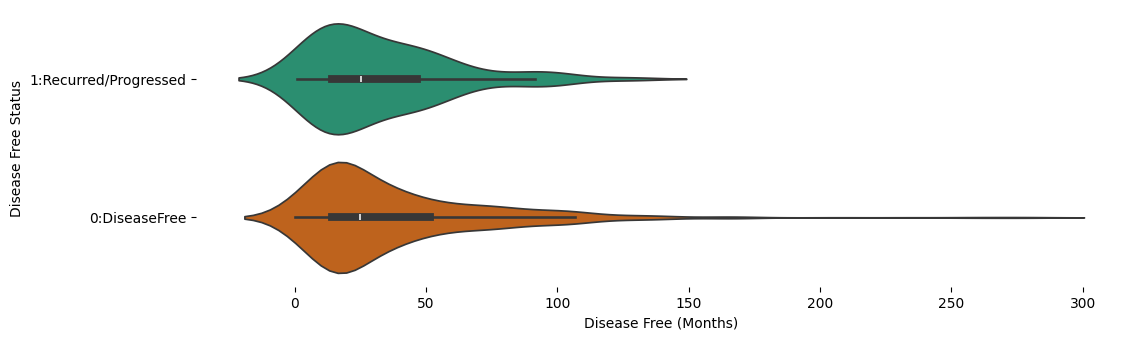

In [ ]:
figsize = (12, 1.2 * len(data_endpoint['Disease Free Status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data_endpoint, x='Disease Free (Months)', y='Disease Free Status', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
for col in ['Disease Free Status','Disease-specific Survival status','Overall Survival Status','Progression Free Status']:
  print(col)
  print('No of unique entries :', len(data[col].unique()))
  print('Unique Entries : ',data[col].unique())

Disease Free Status
No of unique entries : 3
Unique Entries :  ['1:Recurred/Progressed' '0:DiseaseFree' nan]
Disease-specific Survival status
No of unique entries : 3
Unique Entries :  ['0:ALIVE OR DEAD TUMOR FREE' '1:DEAD WITH TUMOR' nan]
Overall Survival Status
No of unique entries : 2
Unique Entries :  ['0:LIVING' '1:DECEASED']
Progression Free Status
No of unique entries : 3
Unique Entries :  ['1:PROGRESSION' '0:CENSORED' nan]


In [ ]:
cols_to_convert = [
    'Disease Free Status',
    'Disease-specific Survival status',
    'Overall Survival Status',
    'Progression Free Status'
]

# Convert by extracting number before colon and casting to float
for col in cols_to_convert:
    data[col] = data[col].str.extract(r'(^\d)').astype(float)

In [ ]:
data_endpoint = data[endpoint]
data_endpoint.head()

,Disease Free Status,Disease Free (Months),Disease-specific Survival status,Overall Survival Status,Overall Survival (Months),Progression Free Status,Progress Free Survival (Months)
0,1.0,59.440444,0.0,0.0,133.050597,1.0,59.440444
1,0.0,131.669790,0.0,0.0,131.669790,0.0,131.669790
2,0.0,48.459743,0.0,0.0,48.459743,0.0,48.459743
3,NaN,NaN,0.0,0.0,47.604958,0.0,47.604958
4,0.0,11.440971,0.0,0.0,11.440971,0.0,11.440971


In [ ]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

In [ ]:
data_y[0]

np.void((True, 72.0), dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [ ]:
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


Text(0.5, 0, 'time $t$')

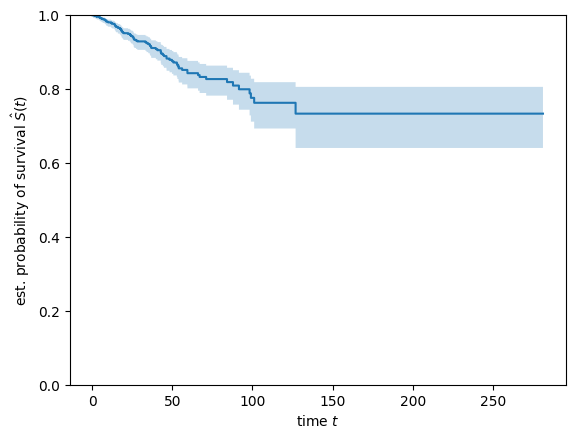

In [ ]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    data_surv[endpoint[0]], data_surv[endpoint[1]], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [ ]:
conf_int

array([[1.        , 1.        , 1.        , ..., 0.64056552, 0.64056552,
        0.64056552],
       [1.        , 1.        , 1.        , ..., 0.80591449, 0.80591449,
        0.80591449]])

In [ ]:
def kaplan_meier(factor,endpoint=[endpoint[0],endpoint[1]]):
  data_km = data[[factor,endpoint[0],endpoint[1]]]
  data_km = data_km.dropna()
  for value in data_km[factor].unique():
      mask = data_km[factor] == value
      time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
          data_km[endpoint[0]][mask].astype(bool), data_km[endpoint[1]][mask], conf_type="log-log")

      plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
      plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

  fig = plt.gcf()                 # Get current figure
  fig.set_size_inches(13, 6)      # Set new width x height in inches
  plt.ylim(0, 1)
  plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
  plt.xlabel("time $t$")
  plt.title("Factor : {factor}, Endpoint : {endpoint[0]}".format(factor=factor,endpoint=endpoint))
  plt.legend(loc="lower left")

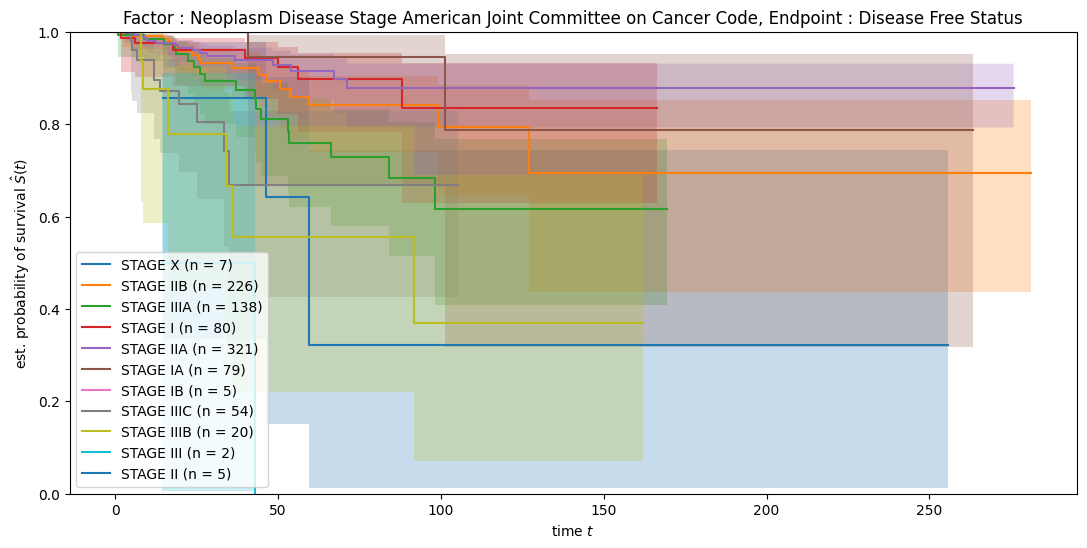

In [ ]:
factor = 'Neoplasm Disease Stage American Joint Committee on Cancer Code'
kaplan_meier(factor)

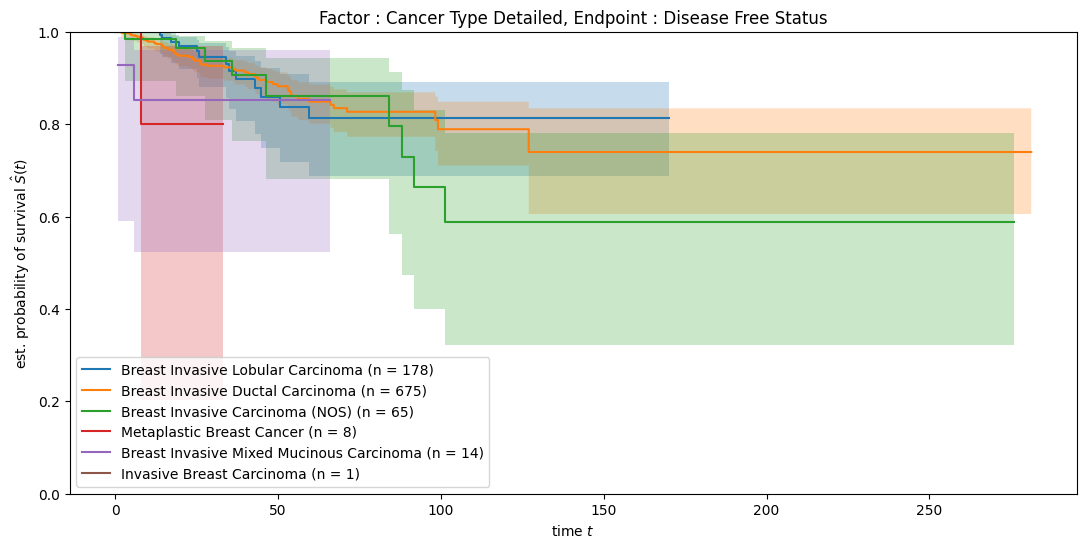

In [ ]:
factor = 'Cancer Type Detailed'
kaplan_meier(factor)

# Cox model

In [ ]:
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


In [ ]:
data_x['Prior_therapy'].dtype

CategoricalDtype(categories=['no', 'yes'], ordered=False, categories_dtype=object)

In [ ]:
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [ ]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [ ]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

,0
Age_in_years,-0.008549
Celltype=large,-0.788672
Celltype=smallcell,-0.331813
Celltype=squamous,-1.188299
Karnofsky_score,-0.032622
Months_from_Diagnosis,-0.000092
Prior_therapy=yes,0.072327
Treatment=test,0.289936


In [ ]:
data.columns

Index(['Patient ID', 'Sample ID', 'Diagnosis Age',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'Aneuploidy Score', 'Buffa Hypoxia Score', 'Cancer Type Detailed',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date', 'Disease Free (Months)',
       'Disease Free Status', 'Months of disease-specific survival',
       'Disease-specific Survival status', 'Ethnicity Category',
       'Form completion date', 'Fraction Genome Altered',
       'Genetic Ancestry Label',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',
       'In PanCan Pathway Analysis', 'MSI MANTIS Score', 'MSIsensor Score',
       'Mutation Count', 'New Neoplasm Eve

In [ ]:
cox_compare = ['Aneuploidy Score','Buffa Hypoxia Score','Diagnosis Age','ICD-10 Classification','Race Category','Tumor Break Load']
data_cox = data[cox_compare]
data_cox_numeric = OneHotEncoder().fit_transform(data_cox)

In [ ]:
data_cox_numeric

,Aneuploidy Score,Buffa Hypoxia Score,Diagnosis Age,ICD-10 Classification=C50.3,ICD-10 Classification=C50.4,ICD-10 Classification=C50.5,ICD-10 Classification=C50.8,ICD-10 Classification=C50.9,ICD-10 Classification=C50.919,Race Category=Asian,Race Category=Black or African American,Race Category=White,Tumor Break Load
0,19.0,-21.0,55,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,205.0
1,22.0,5.0,50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,190.0
2,13.0,-5.0,62,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,365.0
3,4.0,-27.0,52,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,25.0
4,7.0,-27.0,50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,18.0,-21.0,77,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,12.0
1080,4.0,-37.0,46,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,59.0
1081,32.0,-31.0,68,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,51.0
1082,21.0,-13.0,61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0


In [ ]:
endpoint[0]

'Disease Free Status'

In [ ]:
estimator_trial = CoxPHSurvivalAnalysis()
estimator_trial.fit(data_cox_numeric, data_y)

In [ ]:
def cox(factor, samples = 5, endpoint=[endpoint[0],endpoint[1]]):
  data_cox = data[factor+[endpoint[0],endpoint[1]]]
  data_cox = data_cox.dropna()

  data_cox_numeric = OneHotEncoder().fit_transform(data_cox[factor])
  factor_enc = data_cox_numeric.columns
  data_cox[endpoint[0]] = data_cox[endpoint[0]].astype(bool)

  data_end = np.array(
    list(zip(data_cox[endpoint[0]], data_cox[endpoint[1]])),
    dtype=[('status', 'bool'), ('time', 'f8')])

  set_config(display="text")  # displays text representation of estimators

  estimator = CoxPHSurvivalAnalysis()
  estimator.fit(data_cox_numeric, data_end)
  print(pd.Series(estimator.coef_, index=data_cox_numeric.columns))

  samples = np.arange(samples)
  pred_surv = estimator.predict_survival_function(data_cox_numeric.iloc[samples][factor_enc])
  time_points = np.arange(1, max(data_cox[endpoint[1]]))
  for i, surv_func in enumerate(pred_surv):
      plt.step(time_points, surv_func(time_points), where="post", label=f"Sample {i + 1}")
  plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
  plt.xlabel("time $t$")
  plt.legend(loc="best")

Aneuploidy Score       0.004972
Buffa Hypoxia Score    0.010665
Diagnosis Age         -0.008074
Tumor Break Load      -0.000612
dtype: float64


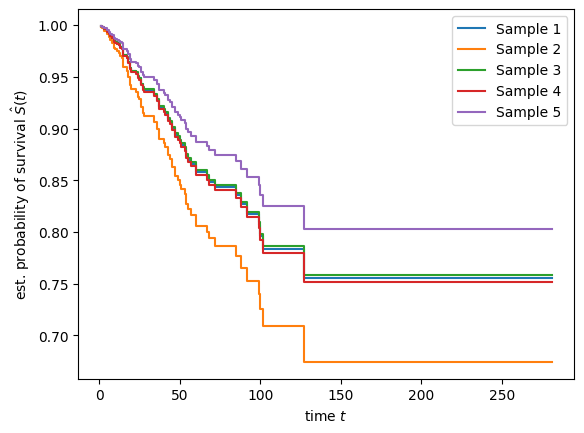

In [ ]:
cox(cox_compare)

In [ ]:
def fit_and_score_features(endpoint=[endpoint[0],endpoint[1]]):
    col_remove = list(data.select_dtypes(include='object').columns)
    col_remove = col_remove + [endpoint[0], endpoint[1]]

    X_enc = OneHotEncoder().fit_transform(data.drop(columns=col_remove))
    n_features = X_enc.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
      # Extract j-th column
      Xj = X_enc.iloc[:, j : j + 1]
      data[endpoint[0]] = data[endpoint[0]].astype(bool)
      # Find rows without NaNs in that column
      non_na_mask = (~Xj.isna().any(axis=1) &~data[endpoint[0]].isna() &~data[endpoint[1]].isna())

      # Filter X and endpoint
      Xj = Xj[non_na_mask]
      data_end = np.array(list(zip(data.loc[non_na_mask, endpoint[0]],
                                  data.loc[non_na_mask, endpoint[1]])),
                        dtype=[('status', 'bool'), ('time', 'f8')])
      m.fit(Xj, data_end)
      scores[j] = m.score(Xj, data_end)
    return scores, X_enc


scores, X_enc = fit_and_score_features()
ranking = pd.Series(scores, index=X_enc.columns).sort_values(ascending=False)
ranking

,0
Progress Free Survival (Months),0.998569
Progression Free Status=1.0,0.950629
New Neoplasm Event Post Initial Therapy Indicator=Yes,0.906441
Disease-specific Survival status=1.0,0.745317
Overall Survival Status=1.0,0.737191
...,...
Cancer Type Detailed=Breast Invasive Ductal Carcinoma,0.493829
Oncotree Code=IDC,0.493829
Tumor Type=Other,0.493744
American Joint Committee on Cancer Metastasis Stage Code=MX,0.492386


In [ ]:
ranking.iloc[20:40]

,0
Genetic Ancestry Label=AFR_ADMIX,0.529154
Cancer Type Detailed=Breast Invasive Lobular Carcinoma,0.526795
Tumor Type=Infiltrating Lobular Carcinoma,0.526795
Oncotree Code=ILC,0.526795
Birth from Initial Pathologic Diagnosis Date,0.525782
Primary Lymph Node Presentation Assessment=Yes,0.524097
Subtype=BRCA_Her2,0.523065
Diagnosis Age,0.522964
In PanCan Pathway Analysis=Yes,0.521897
MSIsensor Score,0.520154


# Shapley Plots

In [93]:
import shap
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def shapley_plot(runner, model):
  X = runner.X_train.values.astype('float32')  #runner.X_train is a DataFrame
  col_name = runner.X_train.columns

  # Train-test split
  X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

  # Back to torch tensors
  X_train = torch.tensor(X_train)
  X_test = torch.tensor(X_test)

  explainer = shap.DeepExplainer(model.encoder, X_train)
  shap_values = explainer.shap_values(X_test)

  shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = col_name, show = False)
  plt.title("SHAP Feature Importance")
  plt.savefig("results/figures/shap_bar_plot.png", bbox_inches='tight', dpi=300)
  plt.clf()

In [94]:
shapley_plot(runner, model)

<Figure size 800x950 with 0 Axes>

In [84]:
explanation = shap.Explanation(values=shap_values[:,:,0],
                               base_values=explainer.expected_value[0],
                               data=X_test,
                               feature_names=col_name)

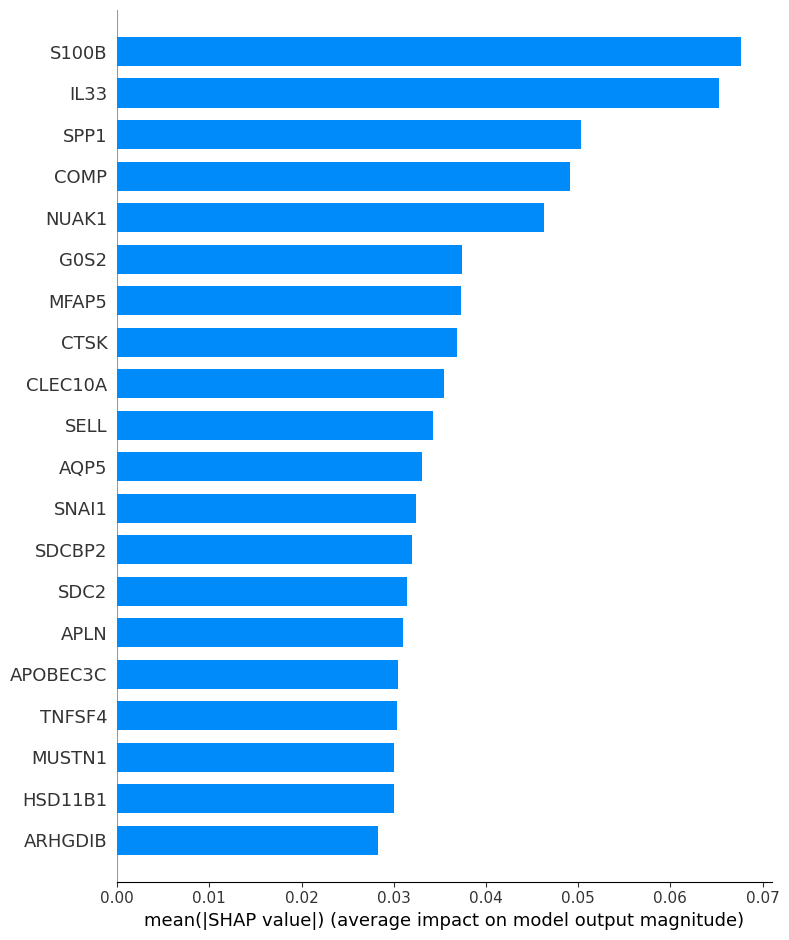

In [88]:
shap.summary_plot(shap_values[:,:,0], X_test, plot_type="bar", feature_names = col_name)

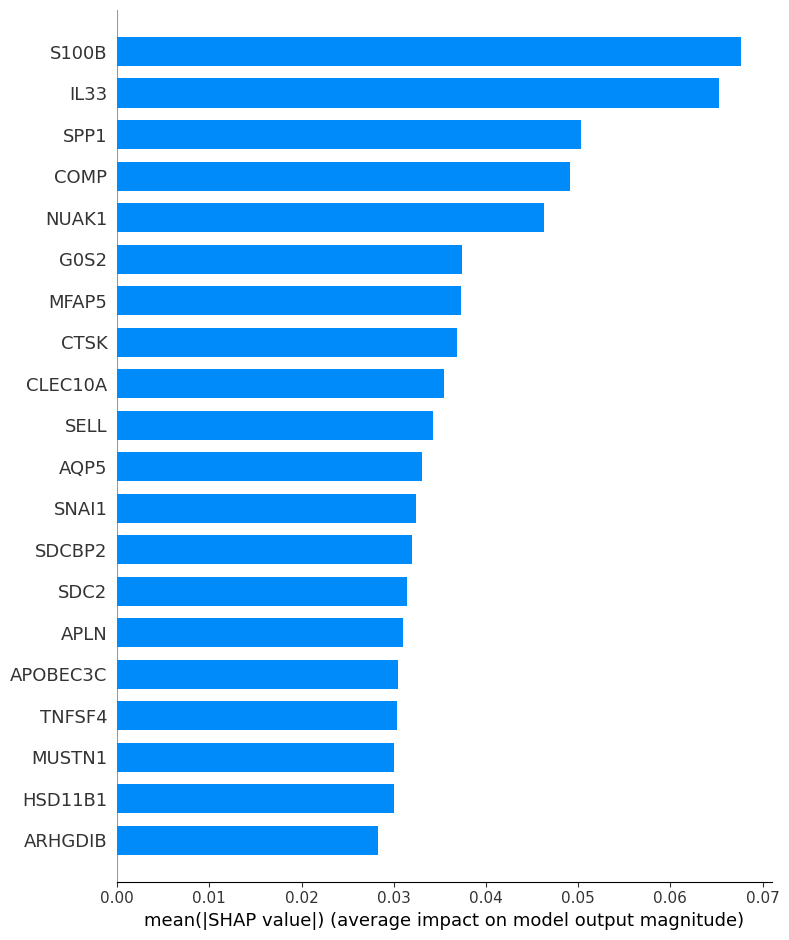

In [71]:
shap.summary_plot(explanation, plot_type="bar")

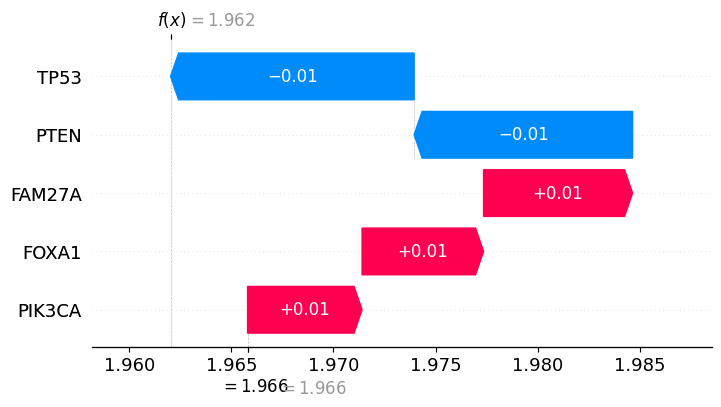

In [79]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[4], shap_values[0][4], feature_names = col_name)

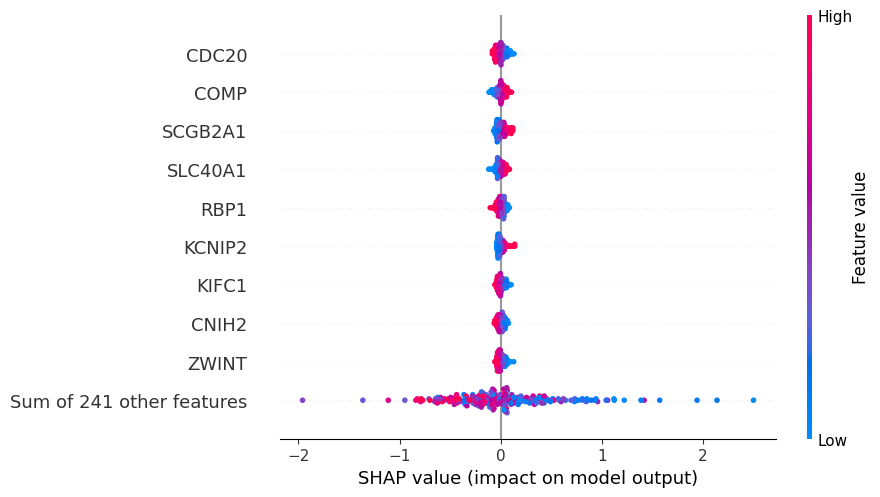

In [85]:
shap.plots.beeswarm(explanation)

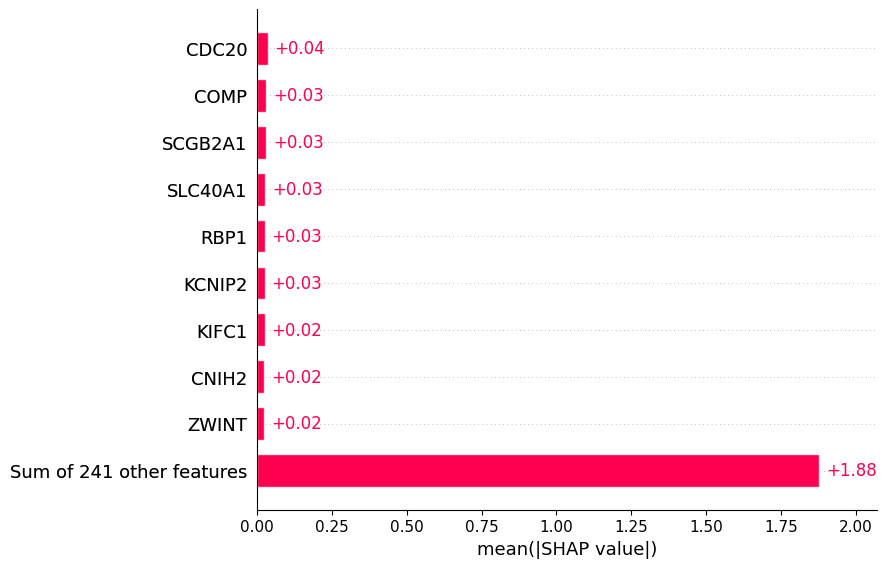

In [86]:
shap.plots.bar(explanation)